2025-04-10 09:53:56,777 - INFO - Dataset loaded successfully. Shape: (22474, 68)


2025-04-10 09:53:56,777 - INFO - Dataset loaded successfully. Shape: (22474, 68)


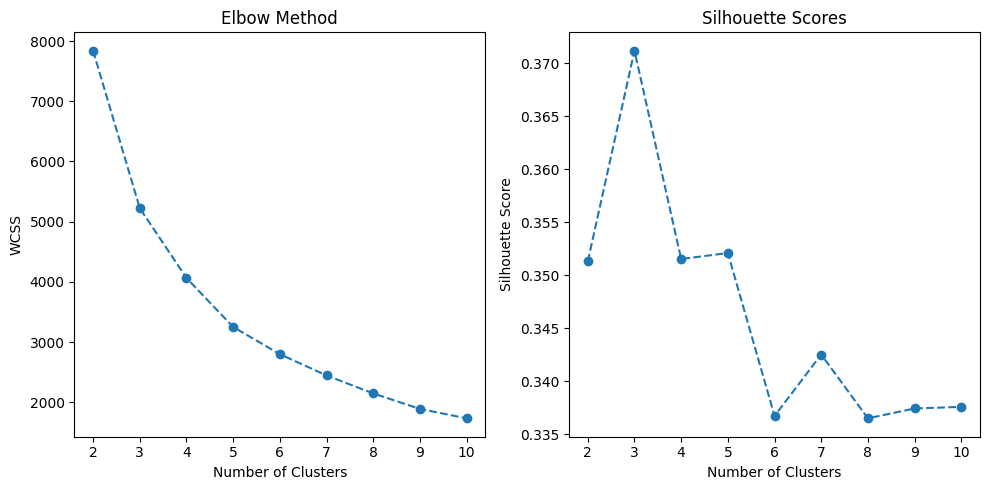

2025-04-10 09:53:58,464 - INFO - Optimal number of clusters based on silhouette score: 3


2025-04-10 09:53:58,464 - INFO - Optimal number of clusters based on silhouette score: 3


2025-04-10 09:53:58,603 - INFO - Clustered data saved to clustered_data.csv.


2025-04-10 09:53:58,603 - INFO - Clustered data saved to clustered_data.csv.


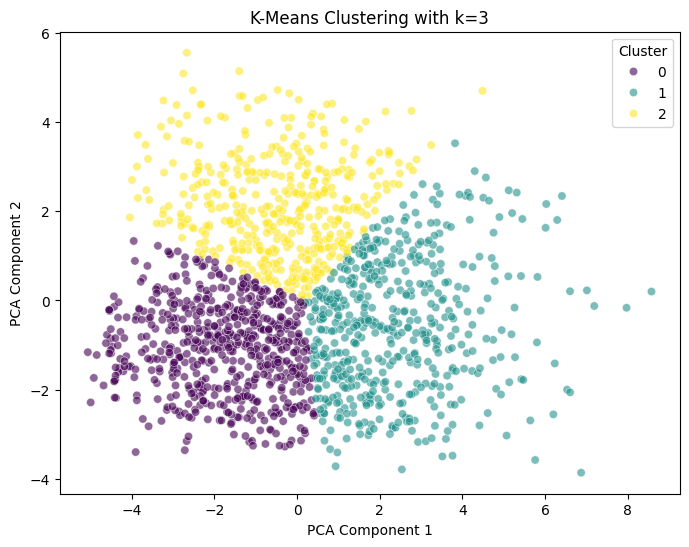


📊 Percentage of each response level (0=Very Helpful, 1=Somewhat, 2=Not Helpful) per Cluster:
         MH9A_0  MH9A_1 MH9A_2  MH9B_0  MH9B_1 MH9B_2  MH9C_0  MH9C_1 MH9C_2  \
Cluster                                                                        
0        80.31%  17.44%  2.25%  73.58%  23.14%  3.28%  81.52%  17.10%  1.38%   
1        63.60%  28.74%  7.66%  65.90%  29.69%  4.41%  67.82%  27.59%  4.60%   
2        73.39%  23.85%  2.75%  68.12%  27.29%  4.59%  74.54%  23.85%  1.61%   

         MH9D_0  ... MH9E_2  MH9F_0  MH9F_1 MH9F_2  MH9G_0  MH9G_1 MH9G_2  \
Cluster          ...                                                        
0        74.27%  ...  1.04%  77.20%  20.90%  1.90%  76.86%  20.73%  2.42%   
1        62.84%  ...  3.07%  60.34%  32.95%  6.70%  61.88%  31.99%  6.13%   
2        65.14%  ...  0.69%  68.58%  27.06%  4.36%  71.33%  26.38%  2.29%   

         MH9H_0  MH9H_1 MH9H_2  
Cluster                         
0        79.62%  19.17%  1.21%  
1        68.39%  25.

C:\Users\Bely\AppData\Local\Temp\ipykernel_12852\2756236797.py:109: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(cluster_percentage_df.applymap(lambda x: f"{x:.2f}%"))


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import os
import sys
sys.path.append(os.path.abspath('../src'))
from logg import logger  

# Load dataset
data_path = "../data/processed_data_helpfulness.csv"
df = pd.read_csv(data_path)
logger.info(f"Dataset loaded successfully. Shape: {df.shape}")
target_columns = ['MH9A', 'MH9B', 'MH9C', 'MH9D', 'MH9E', 'MH9F', 'MH9G', 'MH9H']

# Replace 99 with NaN in target columns
df[target_columns] = df[target_columns].replace(99, np.nan)

# Drop rows with NaN in target columns
df = df.dropna(subset=target_columns)

# Prepare features for clustering (exclude target columns)
X = df.drop(columns=target_columns, errors='ignore')

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Determine optimal number of clusters using Elbow and Silhouette methods
wcss = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot Elbow and Silhouette
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Choose optimal k (highest silhouette score)
optimal_k = k_values[np.argmax(silhouette_scores)]
logger.info(f"Optimal number of clusters based on silhouette score: {optimal_k}")

# Final KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_pca)

# Save clustered data
df.to_csv("../data/clustered_data.csv", index=False)
logger.info("Clustered data saved to clustered_data.csv.")

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'K-Means Clustering with k={optimal_k}')
plt.legend(title='Cluster')
plt.show()

# Calculate response percentage per cluster for each target column (MH9A, MH9B, etc.)
cluster_percentage_distributions = {}

for col in target_columns:
    # Group by cluster and calculate value counts for each response level (0, 1, 2)
    counts_per_cluster = df.groupby('Cluster')[col].value_counts(normalize=True).unstack(fill_value=0) * 100
    counts_per_cluster.columns = [f"{col}_{int(c)}" for c in counts_per_cluster.columns]  # Rename columns for clarity
    
    # Round percentages to two decimal places
    counts_per_cluster = counts_per_cluster.round(2)
    
    # Store the result for each column
    cluster_percentage_distributions[col] = counts_per_cluster

# Combine all percentages into a single DataFrame
cluster_percentage_df = pd.concat(cluster_percentage_distributions.values(), axis=1)

# Display the percentage DataFrame with two decimal places and percentage sign
print("\n📊 Percentage of each response level (0=Very Helpful, 1=Somewhat, 2=Not Helpful) per Cluster:")
print(cluster_percentage_df.applymap(lambda x: f"{x:.2f}%"))
